In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
import os
import tensorflow
from tensorflow import keras
from tensorflow.keras.models import Model
from keras.layers import Input
from keras.models import Sequential, Model
from keras.layers import Conv2D, Dense, MaxPooling2D, Flatten, Dropout, GlobalAveragePooling2D
from keras.preprocessing.image import ImageDataGenerator
from models import resnet_v1, resnet_v2

In [5]:
train_dir = os.path.dirname('/content/drive/MyDrive/generated_dataset/train/')
test_dir = os.path.dirname('/content/drive/MyDrive/generated_dataset/test/')

In [6]:
## Generators ##
 
train_datagen = ImageDataGenerator(
    rescale = 1./255,
    validation_split=0.2,
)

test_datagen = ImageDataGenerator(
    rescale = 1./255,
)


In [7]:
train_dataset = train_datagen.flow_from_directory(
    train_dir,
    #class_mode='binary',
    class_mode='categorical',
    batch_size = 32,
    shuffle=True,
    subset = "training",
    target_size = (224, 224)
)

valid_dataset = train_datagen.flow_from_directory(
    train_dir,
    #class_mode='binary',
    class_mode='categorical',
    batch_size = 32,
    shuffle=True,
    subset="validation",
    target_size = (224, 224)
)

test_dataset = test_datagen.flow_from_directory(
    test_dir,
    #class_mode='binary',
    class_mode='categorical',
    batch_size = 32,
    shuffle=False,
    target_size = (224, 224)
)


Found 5402 images belonging to 2 classes.
Found 1349 images belonging to 2 classes.
Found 3100 images belonging to 2 classes.


In [ ]:
# define model
input_shape = (224,224,3)
depth = 20 # For ResNet, specify the depth (e.g. ResNet50: depth=50)
num_classes = 2
attention_module = 'cbam_block'
model = resnet_v1.resnet_v1(input_shape=input_shape, depth=depth, num_classes=num_classes, attention_module=attention_module)
# model = resnet_v2.resnet_v2(input_shape=input_shape, depth=depth, num_classes=num_classes, attention_module=attention_module)   
# model = inception_v3.InceptionV3(input_shape=input_shape, classes=num_classes, attention_module=attention_module)

model.summary()

In [ ]:
from keras.utils.vis_utils import plot_model
plot_model(model, to_file='model_resent20_cbam.png', show_shapes=True)

In [9]:
from keras.optimizers import SGD, Adam
import numpy
sgd = SGD(lr=0.001, decay=1e-7, momentum=.9)
adam = Adam(learning_rate=0.001)
model.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy'])

In [10]:
from keras.callbacks import ReduceLROnPlateau
from keras.callbacks import ModelCheckpoint
from keras.callbacks import TensorBoard
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy',
                                            patience=1,
                                            verbose=1,
                                            factor=0.25,
                                            min_lr=0.00001)
logs = TensorBoard(log_dir='./logs')

cb_checkpointer = ModelCheckpoint(filepath = 'resnetv1_checkpoint.h5', monitor = 'val_accuracy', save_best_only = True, mode = 'max')

In [ ]:
history = model.fit(train_dataset, validation_data=valid_dataset , epochs = 10, callbacks=[cb_checkpointer, learning_rate_reduction, logs])

Epoch 1/10
169/169 [==============================] - 131s 723ms/step - loss: 0.5783 - accuracy: 0.7934 - val_loss: 1.4655 - val_accuracy: 0.5145
Epoch 2/10
169/169 [==============================] - 115s 679ms/step - loss: 0.3130 - accuracy: 0.9374 - val_loss: 1.1939 - val_accuracy: 0.5760
Epoch 3/10
169/169 [==============================] - 115s 677ms/step - loss: 0.2561 - accuracy: 0.9630 - val_loss: 0.3743 - val_accuracy: 0.9096
Epoch 4/10
169/169 [==============================] - 113s 666ms/step - loss: 0.2504 - accuracy: 0.9636 - val_loss: 0.4523 - val_accuracy: 0.8970

Epoch 00004: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
Epoch 5/10
169/169 [==============================] - 111s 654ms/step - loss: 0.2217 - accuracy: 0.9765 - val_loss: 0.2111 - val_accuracy: 0.9822
Epoch 6/10
169/169 [==============================] - 111s 657ms/step - loss: 0.2034 - accuracy: 0.9836 - val_loss: 0.4267 - val_accuracy: 0.8910

Epoch 00006: ReduceLROnPlateau reducing le

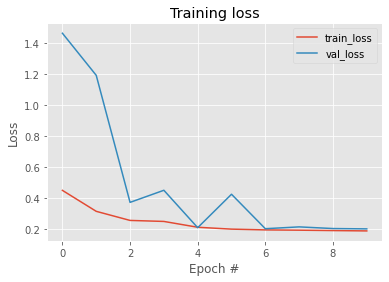

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
N = np.arange(0, 10)
plt.style.use('ggplot')
plt.figure()
plt.plot(N, history.history['loss'], label='train_loss')
plt.plot(N, history.history['val_loss'], label='val_loss')
plt.title('Training loss')
plt.xlabel('Epoch #')
plt.ylabel('Loss')
plt.legend()
plt.show()

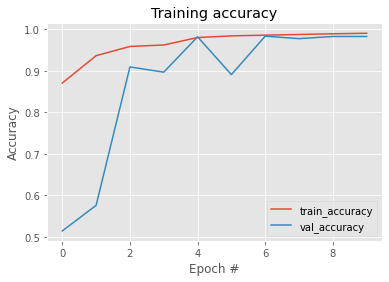

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
N = np.arange(0, 10)
plt.style.use('ggplot')
plt.figure()
plt.plot(N, history.history['accuracy'], label='train_accuracy')
plt.plot(N, history.history['val_accuracy'], label='val_accuracy')
plt.title('Training accuracy')
plt.xlabel('Epoch #')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [ ]:
score = model.evaluate(test_dataset, batch_size=32)
print('Test Loss = ', score[0])
print('Test Accuracy = ', score[1])

In [ ]:
##CONFUSION MATRIX
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
Y_pred = model.predict(test_dataset)
y_pred = np.argmax(Y_pred, axis=1)
print('Confusion Matrix')
cnf_matrix = confusion_matrix(test_dataset.classes, y_pred)
print(cnf_matrix)
print('Classification Report')
target_names = ['Covid', 'Non']
print(classification_report(test_dataset.classes, y_pred, target_names=target_names))

Confusion Matrix
[[  97    3]
 [   4 2996]]
Classification Report
              precision    recall  f1-score   support

       Covid       0.96      0.97      0.97       100
         Non       1.00      1.00      1.00      3000

    accuracy                           1.00      3100
   macro avg       0.98      0.98      0.98      3100
weighted avg       1.00      1.00      1.00      3100



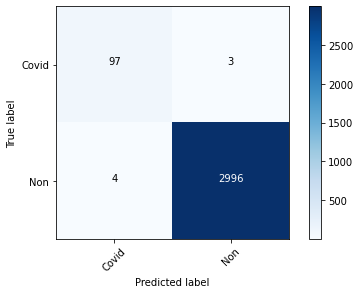

In [ ]:
import itertools
import matplotlib.pyplot as plt

def plot_confusion_matrix(cm, classes,
                          cmap=plt.cm.Blues):

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    plt.grid(False)
    fmt = 'd' 
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                horizontalalignment="center",
                color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
plot_confusion_matrix(cnf_matrix,classes=target_names)

In [15]:
## prediction on some test images
import numpy as np
from PIL import Image
import cv2

test_img_paths = ["/content/drive/MyDrive/generated_dataset/test/covid/1-s2.0-S0929664620300449-gr2_lrg-b.jpg",
                  "/content/drive/MyDrive/generated_dataset/test/non/Enlarged_Cardiomediastinum/patient00307-study1-view1_frontal.jpg",
                  "/content/drive/MyDrive/generated_dataset/test/covid/16660_3_1.jpg"]

#img_list = [Image.open(img_path) for img_path in test_img_paths]
img_list = [cv2.cvtColor(cv2.imread(img_path,1), cv2.COLOR_BGR2RGB)/255 for img_path in test_img_paths]

classes = ['covid', 'non']

test_batch = np.stack(np.array(cv2.resize(img,(224,224)))
                             for img in img_list)

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2822: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  if self.run_code(code, result):


In [16]:
pred_probs = model.predict(test_batch)
pred_probs

array([[9.99892473e-01, 1.07525266e-04],
       [7.50054279e-03, 9.92499411e-01],
       [9.99998927e-01, 1.08020936e-06]], dtype=float32)

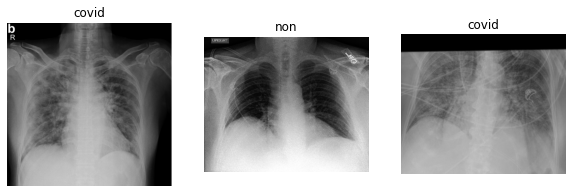

In [17]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(1, len(img_list), figsize=(10, 6))
for i, img in enumerate(img_list):
    ax = axs[i]
    ax.axis('off')
    ax.set_title(classes[np.argmax(pred_probs[i])])
    ax.imshow(img)

In [11]:
##Load Weights
model.load_weights('/content/drive/MyDrive/resnetv1_cbam_rev1.h5')

In [ ]:
##Save Weights
model.save_weights('/content/drive/MyDrive/resnetv1_cbam_rev1.h5')

##Grad CAM

In [12]:
import tensorflow as tf
img_size = (224, 224)

last_conv_layer_name = "conv2d_29"
classifier_layer_names = [
    "flatten",
    "dense_18",
]


In [13]:
def get_img_array(img_path, size):
    # `img` is a PIL image of size 224x224
    img = keras.preprocessing.image.load_img(img_path, target_size=size)
    # `array` is a float32 Numpy array of shape (224, 224, 3)
    array = keras.preprocessing.image.img_to_array(img)
    # We add a dimension to transform our array into a "batch"
    # of size (1, 224, 224, 3)
    array = np.expand_dims(array, axis=0)
    return array


def make_gradcam_heatmap(
    img_array, model, last_conv_layer_name, classifier_layer_names
):
    # First, we create a model that maps the input image to the activations
    # of the last conv layer
    last_conv_layer = model.get_layer(last_conv_layer_name)
    last_conv_layer_model = keras.Model(model.inputs, last_conv_layer.output)

    # Second, we create a model that maps the activations of the last conv
    # layer to the final class predictions
    classifier_input = keras.Input(shape=last_conv_layer.output.shape[1:])
    x = classifier_input
    for layer_name in classifier_layer_names:
        x = model.get_layer(layer_name)(x)
    classifier_model = keras.Model(classifier_input, x)

    # Then, we compute the gradient of the top predicted class for our input image
    # with respect to the activations of the last conv layer
    with tf.GradientTape() as tape:
        # Compute activations of the last conv layer and make the tape watch it
        last_conv_layer_output = last_conv_layer_model(img_array)
        tape.watch(last_conv_layer_output)
        # Compute class predictions
        preds = classifier_model(last_conv_layer_output)
        top_pred_index = tf.argmax(preds[0])
        top_class_channel = preds[:, top_pred_index]

    # This is the gradient of the top predicted class with regard to
    # the output feature map of the last conv layer
    grads = tape.gradient(top_class_channel, last_conv_layer_output)

    # This is a vector where each entry is the mean intensity of the gradient
    # over a specific feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # We multiply each channel in the feature map array
    # by "how important this channel is" with regard to the top predicted class
    last_conv_layer_output = last_conv_layer_output.numpy()[0]
    pooled_grads = pooled_grads.numpy()
    for i in range(pooled_grads.shape[-1]):
        last_conv_layer_output[:, :, i] *= pooled_grads[i]

    # The channel-wise mean of the resulting feature map
    # is our heatmap of class activation
    heatmap = np.mean(last_conv_layer_output, axis=-1)

    # For visualization purpose, we will also normalize the heatmap between 0 & 1
    heatmap = np.maximum(heatmap, 0) / np.max(heatmap)
    return heatmap

In [20]:
# Prepare image
test_path="/content/drive/MyDrive/generated_dataset/test/covid/1.CXRCTThoraximagesofCOVID-19fromSingapore.pdf-000-fig1a.png"
img_array = get_img_array(test_path, size=img_size)
img_array = img_array/255

# Make model
model = model

# Print what the top predicted class is
preds = model.predict(img_array)
print("Predicted:", classes[np.argmax(preds[0])])

# Generate class activation heatmap
heatmap = make_gradcam_heatmap(
    img_array, model, last_conv_layer_name, classifier_layer_names
)


Predicted: covid


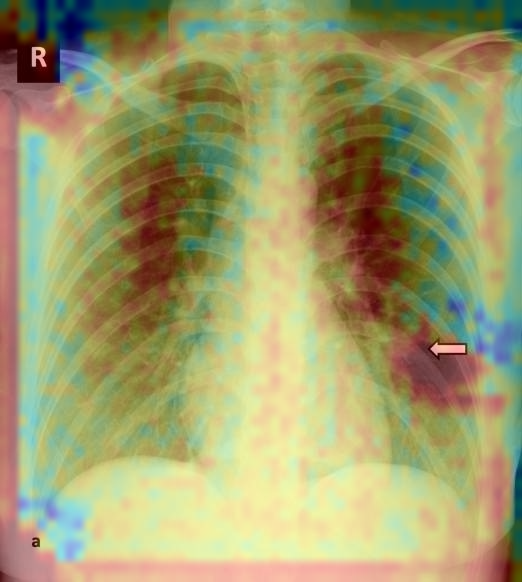

In [19]:
import matplotlib.cm as cm
# We load the original image
img = keras.preprocessing.image.load_img(test_path)
img = keras.preprocessing.image.img_to_array(img)
# We rescale heatmap to a range 0-255
heatmap = np.uint8(255 * heatmap)

# We use jet colormap to colorize heatmap
jet = cm.get_cmap("jet")

# We use RGB values of the colormap
jet_colors = jet(np.arange(256))[:, :3]
jet_heatmap = jet_colors[heatmap]

# We create an image with RGB colorized heatmap
jet_heatmap = keras.preprocessing.image.array_to_img(jet_heatmap)
jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
jet_heatmap = keras.preprocessing.image.img_to_array(jet_heatmap)

# Superimpose the heatmap on original image
superimposed_img = jet_heatmap * 0.5 + img
superimposed_img = keras.preprocessing.image.array_to_img(superimposed_img)
display(superimposed_img)
